In [1]:
from pychomp2 import *

## Simplicial Flow Example

Given a simplicial complex $X$, a _discrete vector field_ on $X$ is a [matching](https://en.wikipedia.org/wiki/Matching_(graph_theory)) on the simplices of $X$ such that two simplices are only matched if one is a codimension-1 face (i.e. a facet) of the other. An example is illustrated here:

![SimplicialFlowExample](./SimplicialFlowExample.png "Simplicial Complex with Discrete Vector Field")

Define an _attractor subcomplex_ $A$ to be a combinatorially closed subcomplex of the simplicial complex such that for any matched simplices $\sigma$ and $\tau$, $\sigma \in A$ if and only if $\tau \in A$. The collection of attractor subcomplexes, partially ordered by inclusion, comprise a lattice $L$. The join-irreducible elements of $L$ yield a poset $P$ (from which $L$ can be recovered via [Birkhoff's Representation Theorem](https://en.wikipedia.org/wiki/Birkhoff%27s_representation_theorem)). We define a map $F$, which we call the _cell fibration_ to be the map $\sigma \mapsto \cap_{\sigma \in A \in L} A$. It is not difficult to see that $F(\sigma) \in P$ for each simplex $\sigma$. We call the preimages $F^{-1}(p)$ for $p \in P$ _fibers_. The poset $P$ and the associated fibers may be computed via [Tarjan's Algorithm for Strongly Connected Components](https://en.wikipedia.org/wiki/Tarjan%27s_strongly_connected_components_algorithm) applied to the graph of simplices with directed edges from each simplex to its facets and from each matched simplex to its mate in the matching. This provides a setting in which the theory of connection matrices applies. More information on the computation of the connection matrix be found [here](https://shaunharker.github.io/2016-12-15-Workshop/#1).

## Create the Simplicial Complex

In [2]:
sc = SimplicialComplex([[0,1,2],[0,2,3]])

## Create a Discrete Vector Field

In [3]:
class DiscreteVectorField:
    def __init__(self, c):
        self.c = c
        self.pairing = {}
        for i in c:
            self.pairing[tuple(self.c.simplex(i))] = self.c.simplex(i)
    def add_pair(self, s, t):
        self.pairing[tuple(s)] = t
        self.pairing[tuple(t)] = s        
    def __call__(self, i):
        return self.c.idx(self.pairing[tuple(self.c.simplex(i))])

In [4]:
dvf = DiscreteVectorField (sc)
dvf.add_pair([0], [0,1])
dvf.add_pair([1], [1,2])
dvf.add_pair([2], [0,2])
dvf.add_pair([0,3], [0,2,3])

## Create a Multivalued Map

In [5]:
# create multivalued map
def F(i):
    """
    A simplex maps to its mate (under the discrete vector field) and its boundary cells
    """
    return sc.boundary({i}) | {dvf(i)}

In [6]:
# human legible multivalued map
{ tuple(sc.simplex(i)) : [ sc.simplex(j) for j in F(i)] for i in sc}

{(0,): [[0, 1]],
 (1,): [[1, 2]],
 (2,): [[0, 2]],
 (3,): [[3]],
 (0, 1): [[0], [1]],
 (0, 2): [[0], [2]],
 (0, 3): [[0], [0, 2, 3], [3]],
 (1, 2): [[1], [2]],
 (2, 3): [[2, 3], [2], [3]],
 (0, 1, 2): [[0, 1, 2], [0, 1], [0, 2], [1, 2]],
 (0, 2, 3): [[2, 3], [0, 2], [0, 3]]}

## Compute the Birkhoff representation of the lattice of representable attractors

In [7]:
vertices = [ cell for cell in sc]
(condensation_graph, component_map) = CondensationGraph(vertices, F)

In [8]:
labels = {}
for v in vertices:
    comp = component_map[v]
    if comp not in labels:
        labels[comp] = set()
    labels[comp].add(tuple(sc.simplex(v)))
P = Poset(condensation_graph)
P.children_.vertex_labels_ = { comp : str(labels[comp]) for comp in condensation_graph.vertices() }

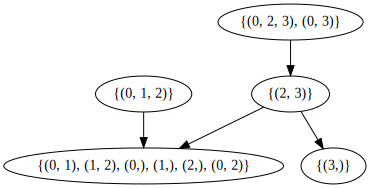

In [9]:
P

## Construct Cell Fibration object

In [10]:
graded_complex = GradedComplex(sc, lambda v : component_map[v]) 

The computation then precedes by computing the homological Conley Index of the pairs $(N_p, L_p)$ where $N_p$ is the combinatorially closed subcomplex with cells $f^{-1}(\{ x \in P : x \leq p\})$, (i.e. the attracting block corresponding to the node p) and L_p is the is the combinatorially closed subcomplex with cells $f^{-1}(\{ x \in P : x < p\})$ of the poset P. In fact, we get more, we also get a connection matrix, and the recipe for this is to reduce the complex via reductions that never collapse pairs which are not assigned to the same poset vertex (i.e. combinatorial morse set).

## Compute Connection Matrix

In [11]:
connection_matrix = ConnectionMatrix(graded_complex)

## Visualize Connection Matrix

The connection matrix is a cell fibration from a reduced complex to the poset `P`.

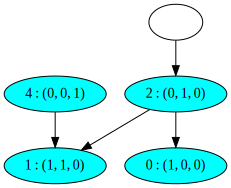

In [12]:
# Conley-Morse Graph
DrawGradedComplex(connection_matrix, P)

In [13]:
for i in connection_matrix.complex():
    print("cell = " + str(i) + ", poset vertex " + str(connection_matrix.value(i)) + ", boundary = " + str(connection_matrix.complex().boundary({i})))
    

cell = 0, poset vertex 1, boundary = set()
cell = 1, poset vertex 0, boundary = set()
cell = 2, poset vertex 1, boundary = set()
cell = 3, poset vertex 2, boundary = {0, 1}
cell = 4, poset vertex 4, boundary = {2}


In [14]:
# Connection Matrix Entries
for generator in connection_matrix.complex():
    print(str(generator) + " : " + str(connection_matrix.complex().boundary({generator})))

0 : set()
1 : set()
2 : set()
3 : {0, 1}
4 : {2}


In [15]:
df = DrawGradedComplex(connection_matrix, P)

In [16]:
df.graphviz()

'digraph {\n0[label="0 : (1, 0, 0)", style=filled, fillcolor=cyan];\n1[label="1 : (1, 1, 0)", style=filled, fillcolor=cyan];\n2[label="2 : (0, 1, 0)", style=filled, fillcolor=cyan];\n3[label=" "];\n4[label="4 : (0, 0, 1)", style=filled, fillcolor=cyan];\n2 -> 0;\n2 -> 1;\n3 -> 2;\n4 -> 1;\n}\n'

In [17]:
# with open("example.gv", "w") as outfile:
#     outfile.write(df.graphviz())

In [18]:
cc = connection_matrix.complex()

In [19]:
for i in connection_matrix.complex():
    print("cell = " + str(i) + ", poset vertex " + str(connection_matrix.value(i)) + ", boundary = " + str(connection_matrix.complex().boundary({i})))

cell = 0, poset vertex 1, boundary = set()
cell = 1, poset vertex 0, boundary = set()
cell = 2, poset vertex 1, boundary = set()
cell = 3, poset vertex 2, boundary = {0, 1}
cell = 4, poset vertex 4, boundary = {2}


In [20]:
[ connection_matrix.complex().size(d) for d in range(0,connection_matrix.complex().dimension()+1)]

[2, 2, 1]

In [21]:
cmc = connection_matrix.complex()

In [22]:
[ (i, [ sc.simplex(j) for j in cmc.lift({i})]) for i in cmc]

[(0, [[2]]),
 (1, [[3]]),
 (2, [[0, 1], [0, 2], [1, 2]]),
 (3, [[2, 3]]),
 (4, [[0, 1, 2]])]

In [23]:
sc.simplex(8)

[2, 3]